In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
# 
from cryptocmd import CmcScraper
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42

In [3]:
# daily data download
# https://github.com/guptarohit/cryptoCMD
# http://webcache.googleusercontent.com/search?q=cache:https://medium.com/geekculture/3-simple-ways-to-obtain-cryptocurrency-data-in-python-f45b9d603a97&strip=0&vwsrc=1&referer=medium-parser
scraper = CmcScraper("ETH")# Pandas dataFrame for the same data
df = scraper.get_dataframe()
df.drop(columns=['Time Open', 'Time High', 'Time Low', 'Time Close'], inplace=True)
df.sort_values(by=['Date'],inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05,1.666106e+08
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05,4.548689e+07
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05,4.239957e+07
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05,4.281836e+07
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06,6.456929e+07
...,...,...,...,...,...,...,...
3196,2024-05-07,3062.750950,3129.081290,3003.013616,3006.577114,1.174319e+10,3.610631e+11
3197,2024-05-08,3006.315715,3037.196016,2938.472761,2973.657244,1.179166e+10,3.571839e+11
3198,2024-05-09,2973.971683,3057.958361,2951.223960,3036.020583,1.086195e+10,3.646673e+11
3199,2024-05-10,3036.231258,3052.729459,2881.000634,2909.791147,1.227865e+10,3.494937e+11


In [4]:
# Feature Engineering (on Returns, not on Price)
df['Volume'] = df['Volume'].replace(0, pd.NA)
df['Volume'] = df['Volume'].fillna(method='ffill')
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
df['Rv'] = df['Volume'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
ema_14_rv = df.ta.ema(length=14, close='Rv')
rsi_14_rv = df.ta.rsi(length=14, close='Rv')
emsd_rp = df['Rp'] - ema_14_rp
emsd_rv = df['Rv'] - ema_14_rv
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['Rv_ema_14'] = ema_14_rv
df['Rv_rsi_14'] = rsi_14_rv
df['EMSD_Rp'] = emsd_rp
df['EMSD_Rv'] = emsd_rv
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Volume,Market Cap,Rp,Rv,Rp_ema_14,Rp_rsi_14,Rv_ema_14,Rv_rsi_14,EMSD_Rp,EMSD_Rv
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05,1.666106e+08,-0.728250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05,4.548689e+07,-0.068268,3.102672,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05,4.239957e+07,0.009333,-0.210650,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05,4.281836e+07,0.507323,-0.238433,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06,6.456929e+07,0.140075,2.610070,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,2024-05-07,3062.750950,3129.081290,3003.013616,3006.577114,1.174319e+10,3.610631e+11,-0.010949,-0.097274,-0.004387,48.153277,0.024388,48.643326,-0.013947,-0.121662
3197,2024-05-08,3006.315715,3037.196016,2938.472761,2973.657244,1.179166e+10,3.571839e+11,0.020972,0.004128,-0.005262,49.075048,0.021687,49.772987,-0.005688,-0.017559
3198,2024-05-09,2973.971683,3057.958361,2951.223960,3036.020583,1.086195e+10,3.646673e+11,-0.041577,-0.078845,-0.001764,52.967640,0.008282,48.826571,0.022736,-0.087128
3199,2024-05-10,3036.231258,3052.729459,2881.000634,2909.791147,1.227865e+10,3.494937e+11,0.000622,0.130428,-0.007072,45.610631,0.024569,51.339758,-0.034505,0.105860


In [5]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp','Rv_ema_14','Rv_rsi_14','EMSD_Rv']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [6]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Volume,Market Cap,Rp,Rv,Rp_ema_14,Rp_rsi_14,Rv_ema_14,Rv_rsi_14,EMSD_Rp,EMSD_Rv,Predicted_Class
15,2015-08-22,1.396290,1.476410,1.352680,1.379230,9.483100e+05,1.002018e+08,-0.019315,-0.530765,0.004890,56.348887,0.296295,38.661418,-0.016400,-0.827060,1
16,2015-08-23,1.375000,1.409700,1.297770,1.352590,1.589300e+06,9.830035e+07,-0.089695,0.675929,0.001662,56.092597,0.346913,47.092309,-0.020978,0.329016,0
17,2015-08-24,1.345590,1.362780,1.231270,1.231270,9.249200e+05,8.951526e+07,-0.073972,-0.418033,-0.010519,53.719925,0.244920,41.520546,-0.079176,-0.662953,0
18,2015-08-25,1.228610,1.241820,1.128650,1.140190,1.307180e+06,8.292263e+07,0.017357,0.413290,-0.018979,54.186135,0.267369,46.683048,-0.054993,0.145920,3
19,2015-08-26,1.132790,1.202480,1.061830,1.159980,1.056750e+06,8.439092e+07,-0.010586,-0.191580,-0.014134,56.902102,0.206176,43.662780,0.031491,-0.397756,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2024-05-06,3137.510143,3220.152342,3048.238614,3062.728675,1.300859e+10,3.678352e+11,-0.018334,0.481034,-0.002241,47.505750,0.043105,55.220498,-0.021513,0.437929,3
3196,2024-05-07,3062.750950,3129.081290,3003.013616,3006.577114,1.174319e+10,3.610631e+11,-0.010949,-0.097274,-0.004387,48.153277,0.024388,48.643326,-0.013947,-0.121662,3
3197,2024-05-08,3006.315715,3037.196016,2938.472761,2973.657244,1.179166e+10,3.571839e+11,0.020972,0.004128,-0.005262,49.075048,0.021687,49.772987,-0.005688,-0.017559,2
3198,2024-05-09,2973.971683,3057.958361,2951.223960,3036.020583,1.086195e+10,3.646673e+11,-0.041577,-0.078845,-0.001764,52.967640,0.008282,48.826571,0.022736,-0.087128,2


In [7]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: 1.6387747187572252
sharpe_ratio OOS: 1.3164246217226767


In [8]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [9]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",17.517879,1.710469
15,"(3, 4)","[0, 1, 2]",17.041140,0.832318
30,"(1, 2, 3, 4)",[0],13.152638,2.397918
24,"(1, 3, 4)","[0, 2]",12.784039,1.514240
14,"(2, 4)","[0, 1, 3]",12.019076,-0.676048
5,"(4,)","[0, 1, 2, 3]",11.672354,-1.553264
23,"(1, 2, 4)","[0, 3]",8.696123,0.003423
12,"(1, 4)","[0, 2, 3]",8.400336,-0.871162
29,"(0, 2, 3, 4)",[1],4.221914,0.635326
21,"(0, 3, 4)","[1, 2]",3.966651,-0.238886


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
22,"(1, 2, 3)","[0, 4]",-0.626110,2.637646
30,"(1, 2, 3, 4)",[0],13.152638,2.397918
13,"(2, 3)","[0, 1, 4]",1.898432,1.948176
11,"(1, 3)","[0, 2, 4]",-0.870085,1.751488
25,"(2, 3, 4)","[0, 1]",17.517879,1.710469
26,"(0, 1, 2, 3)",[4],-11.672354,1.553264
24,"(1, 3, 4)","[0, 2]",12.784039,1.514240
31,"(0, 1, 2, 3, 4)",[],1.638775,1.316425
4,"(3,)","[0, 1, 2, 4]",1.652663,1.068379
19,"(0, 2, 3)","[1, 4]",-8.400336,0.871162


In [11]:
sharpe_ratios_df['Sharpe_Ratio_OOS'].corr(sharpe_ratios_df['Sharpe_Ratio_IS'])

0.31877575828499977

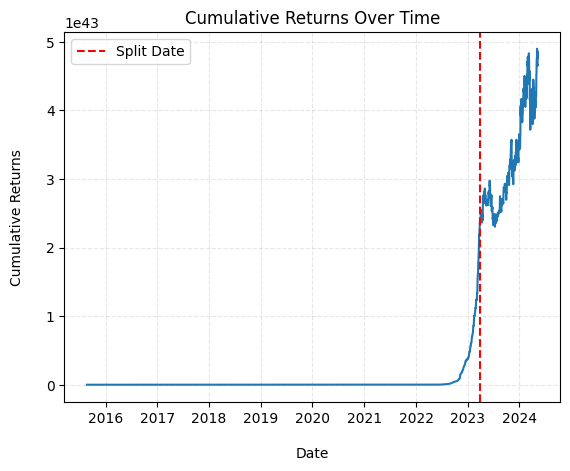

In [12]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()